In [1]:
import os
import geopandas as gpd
import numpy as np
import glob
import matplotlib.pyplot as plt
from osgeo import gdal
import subprocess
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import plotting_extent

In [2]:
# Convert digital number to radiance

def DnToRad ( data, band, gain ):
    gain_settings={'high':0, 'normal':1, 'low1':2, 'low2':3}
    
    conversion_factors=np.array([[0.676, 1.688, 2.25, 0.0],\
        [0.708, 1.415, 1.89, 0.0],\
        [0.423, 0.862, 1.15, 0.0],\
        [0.423, 0.862, 1.15, 0.0],\
        [0.1087, 0.2174, 0.2900, 0.2900],\
        [0.0348, 0.0696, 0.0925, 0.4090],\
        [0.0313, 0.0625, 0.0830, 0.3900],\
        [0.0299, 0.0597, 0.0795, 0.3320],\
        [0.0209, 0.0417, 0.0556, 0.2450],\
        [0.0159, 0.0318, 0.0424, 0.2650]])
    
    radiance = (data - 1.0) * conversion_factors[band-1][gain_settings[gain]]
    return radiance

In [3]:
def RadToRefl ( radiance, band, day, sza, solar_constant_scheme="ThomeEtAl2" ):
    schemes={'Smith':0, 'ThomeEtAl1':1, 'ThomeEtAl2':2}
    
    solar_constant=np.array([[1845.99, 1847, 1848],    \
        [1555.74, 1553, 1549],    \
        [1119.47, 1118, 1114],    \
        [231.25, 232.5,  225.4 ], \
        [79.81,  80.32,  86.63 ], \
        [74.99,  74.92,  81.85 ], \
        [68.66,  69.20,  74.85 ], \
        [59.74,  59.82,  66.49 ], \
        [56.92,  57.32,  59.85]]) #B9
    
    # https://lpdaac.usgs.gov/resources/e-learning/working-aster-l1t-visible-and-near-infrared-vnir-data-r/
    # irradiance <- c(1848,1549,1114,225.4,86.63,81.85,74.85,66.49,59.85)
    
    d = 1.0 - 0.01672 * np.cos(np.radians(0.9856 * (day - 4)))
     
    toaRefl = (np.pi*radiance*d*d)/(solar_constant[band-1][schemes[solar_constant_scheme]]*\
        np.cos (np.radians (sza) ))
    
    return toaRefl

In [4]:
os.chdir('/Users/shannonwhite/git/data/ASTER')

In [5]:
# Open boundary 
boundary_eruption = gpd.read_file(
    '/Users/shannonwhite/git/area_point_layer/POLYGON.shp')

# Set boundary 
boundary_bounds = tuple(boundary_eruption.total_bounds)
boundary_bounds

(-155.91796874999997, 18.999802829053262, -154.7314453125, 19.80805412808859)

* **red band = band 2**
* **NIR band = band 4**

# Pre - NIR band 

In [6]:
# Open data for file 1

file=gdal.Open('AST_L1T_00301052018210609_20180106081940_6702_1.hdf')

# Use file list to select correct band / filename 

##file.GetSubDatasets()

In [7]:
# Write data from .hdf file to .tif file
subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00301052018210609_20180106081940_6702_1.hdf":4', "/Users/shannonwhite/git/data/ASTER/outputA/pre_nir_band_1.tif"])

0

In [8]:
# Open data for file 2

file=gdal.Open('AST_L1T_00301052018210600_20180106081650_1705_2.hdf')
#file.GetSubDatasets()

In [9]:
# Write data from .hdf file to .tif file

subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00301052018210600_20180106081650_1705_2.hdf":4', "outputA/pre_nir_band_2.tif"])


0

In [10]:
# Mosaic NIR (pre) bands
 
nir_aster_pre_glob = glob.glob("outputA/*pre_nir*")
nir_aster_pre_glob.sort()

In [11]:
pre_nir_files_to_mosaic = []

In [12]:
for file in nir_aster_pre_glob:
    src = rio.open(file)
    pre_nir_files_to_mosaic.append(src)
    

In [13]:
ast_pre_nir_out_meta = src.meta.copy()

In [14]:
# Merge files with boundary 

pre_nir_mosaic, pre_nir_out_trans = merge(pre_nir_files_to_mosaic, bounds = boundary_bounds)

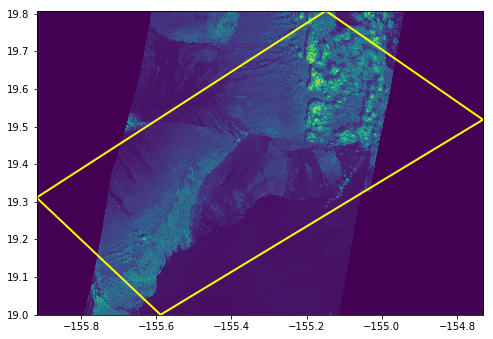

In [15]:
# Plot NIR mosaic with boundary 

nir_extent = plotting_extent(pre_nir_mosaic[0], transform = pre_nir_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(pre_nir_mosaic[0], extent=nir_extent)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='yellow', linewidth=2)
        
plt.show()

## Reflectance Pre NIR 

In [16]:
# Convert radiance values of Aster to reflectance values for NDVI 

reflectance_nir_pre = RadToRefl(DnToRad(pre_nir_mosaic, 2, 'normal'), 2, 16, 90.0-26.830959)

In [17]:
nir_out_transform=ast_pre_nir_out_meta["transform"]

# Pre - Red band

In [18]:
# Write out red bands to tif from the same file as Pre - NIR band above

subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00301052018210609_20180106081940_6702_1.hdf":2', "/Users/shannonwhite/git/data/ASTER/outputA/pre_red_band_1.tif"])

0

In [19]:
# Write out red bands to tif from the same file as Pre - NIR band above

subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00301052018210600_20180106081650_1705_2.hdf":2', "outputA/pre_red_band_2.tif"])


0

In [20]:
with rio.open("outputA/pre_red_band_2.tif") as red_band_2:
    red_arr_2 = red_band_2.read()
    ast_pre_red_out_meta = red_band_2.profile
        

In [21]:
# Mosaic red (pre) bands 

red_aster_pre_glob = glob.glob("outputA/*pre_red*")
red_aster_pre_glob.sort()

In [22]:
pre_red_files_to_mosaic = []

In [23]:
for files in red_aster_pre_glob:
    pre_red_src = rio.open(files)
    pre_red_files_to_mosaic.append(pre_red_src)
    
pre_red_mosaic, pre_red_out_trans = merge(pre_red_files_to_mosaic)

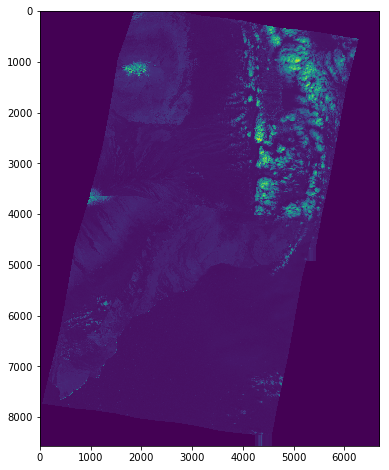

In [24]:
fig, ax1 = plt.subplots(figsize=(8,8))

im=ax1.imshow(pre_red_mosaic[0])

plt.show()

In [25]:
ast_pre_red_out_meta = pre_red_src.profile 

In [26]:
# Merge files with boundary 

pre_red_mosaic, pre_red_out_trans = merge(pre_red_files_to_mosaic, bounds = boundary_bounds)

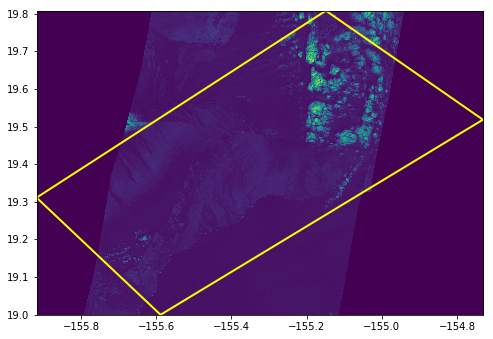

In [27]:
# Plot mosaic of red bands with boundary 

red_extent = plotting_extent(pre_red_mosaic[0], transform = pre_red_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(pre_red_mosaic[0], extent=red_extent)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='yellow', linewidth=2)
        
plt.show()

## Reflectance Pre RED

In [28]:
# Convert radiance values of Aster to reflectance values for NDVI 
reflectance_red_pre = RadToRefl(DnToRad(pre_red_mosaic, 2, 'normal'), 2, 16, 90.0-26.830959)

In [29]:
red_out_transform=ast_pre_red_out_meta["transform"]
ast_pre_red_out_meta['dtype'] = "float64"

In [30]:
# Calculate Pre NDVI 
pre_ndvi = (reflectance_nir_pre [0] - reflectance_red_pre[0])/ (reflectance_nir_pre[0] +reflectance_red_pre [0])

In [31]:
# Write out Pre NDVI

out_path_ndvi_pre='/Users/shannonwhite/git/data/ASTER/outputA/pre_ndvi_rf.tif'

with rio.open(out_path_ndvi_pre,"w",**ast_pre_red_out_meta) as dest:
    dest.write(pre_ndvi, 1)

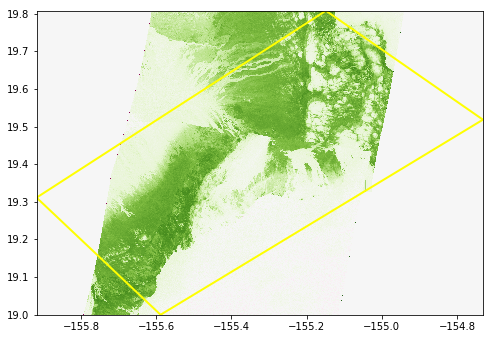

In [32]:
# Plot Pre NDVI

red_extent = plotting_extent(pre_ndvi, transform = pre_red_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(pre_ndvi, extent=red_extent, cmap= 'PiYG', vmin=-1,vmax=1)

boundary_eruption.plot(ax=ax1, color='None', 
                       edgecolor='yellow', linewidth=2)
        
plt.show()

# Post NIR band 

In [33]:
file=gdal.Open('AST_L1T_00311052018210631_20181106100922_1982.hdf')
#file.GetSubDatasets()

In [34]:
# NIR band output #1
subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00311052018210631_20181106100922_1982.hdf":4', "/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_1.tif"])

0

In [35]:
# Red band output #1
subprocess.call(["gdalwarp", "-overwrite",'HDF4_SDS:UNKNOWN:"AST_L1T_00311052018210631_20181106100922_1982.hdf":2', "/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_1.tif"])

0

In [36]:
file=gdal.Open('AST_L1T_00311052018210640_20181106100852_32599.hdf')
#file.GetSubDatasets()

In [37]:
# NIR output #2
subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00311052018210640_20181106100852_32599.hdf":4', "/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_2.tif"])

0

In [38]:
# Red band output #2
subprocess.call(["gdalwarp", "-overwrite",'HDF4_SDS:UNKNOWN:"AST_L1T_00311052018210640_20181106100852_32599.hdf":2', "/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_2.tif"])

0

In [39]:
file=gdal.Open('AST_L1T_00311142018210012_20181115105036_2165.hdf')
#file.GetSubDatasets()

In [40]:
# NIR band output #3
subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00311142018210012_20181115105036_2165.hdf":4', "/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_3.tif"])

0

In [41]:
# Red band output #3
subprocess.call(["gdalwarp", "-overwrite",'HDF4_SDS:UNKNOWN:"AST_L1T_00311142018210012_20181115105036_2165.hdf":2', "/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_3.tif"])

0

In [42]:
file=gdal.Open('AST_L1T_00311142018210021_20181115105256_10141.hdf')
#file.GetSubDatasets()

In [43]:
# NIR band output #4
subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00311142018210021_20181115105256_10141.hdf":4', "/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_4.tif"])

0

In [44]:
# Red band output #4
subprocess.call(["gdalwarp", "-overwrite", 'HDF4_SDS:UNKNOWN:"AST_L1T_00311142018210021_20181115105256_10141.hdf":2', "/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_4.tif"])

0

# Relfectance Post NIR 

In [45]:
# Cannot use reflectance formula because bands have different conversions (normal, low)
# Open band and specify conversion and no data value (= min value)

with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_4.tif") as nir_band_4:
    nir_arr_4 = nir_band_4.read()
    reflectance_nir_post_4 = RadToRefl(DnToRad(nir_arr_4, 2, 'low1'), 2, 319, 90.0-26.830959)
    reflectance_nir_4_meta = nir_band_4.profile
    reflectance_nir_4_meta['nodata']= -0.00830923487373644
    reflectance_nir_4_meta['dtype']='float64'

In [46]:
# Write out file with new reflectance value 

out_path_nir_4 = '/Users/shannonwhite/git/data/ASTER/outputA/post_4_nir_rf.tif'

with rio.open(out_path_nir_4,"w",**reflectance_nir_4_meta) as dest:
    dest.write(reflectance_nir_post_4)

In [47]:
with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_3.tif") as nir_band_3:
    nir_arr_3 = nir_band_3.read()
    reflectance_nir_post_3 = RadToRefl(DnToRad(nir_arr_3, 2, 'low1'), 2, 319, 90.0-26.830959)
    reflectance_nir_3_meta = nir_band_3.profile
    reflectance_nir_3_meta['nodata']= -0.00830923487373644
    reflectance_nir_3_meta['dtype']='float64'

In [48]:
out_path_nir_3 = '/Users/shannonwhite/git/data/ASTER/outputA/post_3_nir_rf.tif'

with rio.open(out_path_nir_3,"w",**reflectance_nir_3_meta) as dest:
    dest.write(reflectance_nir_post_3)

In [49]:
with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_2.tif") as nir_band_2:
    nir_arr_2 = nir_band_2.read()
    reflectance_nir_post_2 = RadToRefl(DnToRad(nir_arr_2, 2, 'normal'), 2, 319, 90.0-26.830959)
    reflectance_nir_2_meta = nir_band_2.profile
    reflectance_nir_2_meta['nodata']= -0.00622093510388205
    reflectance_nir_2_meta['dtype']='float64'

In [50]:
out_path_nir_2 = '/Users/shannonwhite/git/data/ASTER/outputA/post_2_nir_rf.tif'

with rio.open(out_path_nir_2,"w",**reflectance_nir_2_meta) as dest:
    dest.write(reflectance_nir_post_2)

In [51]:
with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_nir_band_1.tif") as nir_band_1:
    nir_arr_1 = nir_band_1.read()
    reflectance_nir_post_1 = RadToRefl(DnToRad(nir_arr_1, 2, 'normal'), 2, 319, 90.0-26.830959)
    reflectance_nir_1_meta = nir_band_1.profile
    reflectance_nir_1_meta['nodata'] = -0.00622093510388205
    reflectance_nir_1_meta['dtype']='float64'


In [52]:
out_path_nir_1 = '/Users/shannonwhite/git/data/ASTER/outputA/post_1_nir_rf.tif'

with rio.open(out_path_nir_1,"w",**reflectance_nir_1_meta) as dest:
    dest.write(reflectance_nir_post_1)

In [53]:
# Mosaic new relfectance 
# Glob all NIR bands 

nir_aster_post_glob = glob.glob("outputA/*nir_rf*")
nir_aster_post_glob.sort()
nir_aster_post_glob

['outputA/post_1_nir_rf.tif',
 'outputA/post_2_nir_rf.tif',
 'outputA/post_3_nir_rf.tif',
 'outputA/post_4_nir_rf.tif']

In [54]:
post_nir_files_to_mosaic = []

In [55]:
for files in nir_aster_post_glob:
    post_nir_src = rio.open(files)
    post_nir_files_to_mosaic.append(post_nir_src)
    
post_nir_mosaic, post_nir_out_trans = merge(post_nir_files_to_mosaic, bounds = boundary_bounds)

post_nir_files_to_mosaic

[<open DatasetReader name='outputA/post_1_nir_rf.tif' mode='r'>,
 <open DatasetReader name='outputA/post_2_nir_rf.tif' mode='r'>,
 <open DatasetReader name='outputA/post_3_nir_rf.tif' mode='r'>,
 <open DatasetReader name='outputA/post_4_nir_rf.tif' mode='r'>]

In [56]:
post_nir_out_meta = post_nir_src.meta.copy()

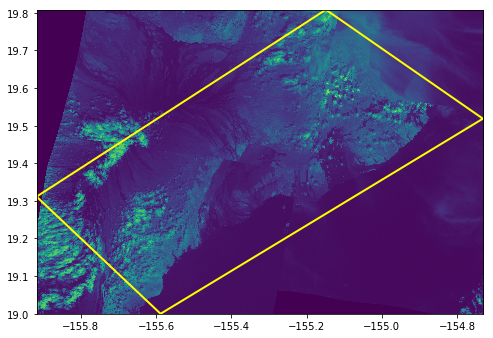

In [57]:
# Plot NIR band 

nir_extent = plotting_extent(post_nir_mosaic[0], transform = post_nir_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(post_nir_mosaic[0], extent=nir_extent)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='yellow', linewidth=2)
        
plt.show()

## Reflectance Red Post 
*same as NIR post procedure*

In [58]:
# Red band 4 = low1

with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_4.tif") as red_band_4:
    red_arr_4 = red_band_4.read()
    reflectance_red_post_4 = RadToRefl(DnToRad(red_arr_4, 2, 'low1'), 2, 319, 90.0-26.830959)
    reflectance_red_4_meta = nir_band_4.profile
    reflectance_red_4_meta['nodata']= -0.008309234873736443
    reflectance_red_4_meta['dtype']='float64'

In [59]:
out_path_red_4 = '/Users/shannonwhite/git/data/ASTER/outputA/post_4_red_rf.tif'

with rio.open(out_path_red_4,"w",**reflectance_red_4_meta) as dest:
    dest.write(reflectance_red_post_4)

In [60]:
# Red band 3 = low1
with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_3.tif") as red_band_3:
    red_arr_3 = red_band_3.read()
    reflectance_red_post_3 = RadToRefl(DnToRad(red_arr_3, 2, 'low1'), 2, 319, 90.0-26.830959)
    reflectance_red_3_meta = nir_band_3.profile
    reflectance_red_3_meta['nodata']= -0.008309234873736443
    reflectance_red_3_meta['dtype']='float64'

In [61]:
out_path_red_3 = '/Users/shannonwhite/git/data/ASTER/outputA/post_3_red_rf.tif'

with rio.open(out_path_red_3,"w",**reflectance_red_3_meta) as dest:
    dest.write(reflectance_red_post_3)

In [62]:
# Red band 2 = high
with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_2.tif") as red_band_2:
    red_arr_2 = red_band_2.read()
    reflectance_red_post_2 = RadToRefl(DnToRad(red_arr_2, 2, 'high'), 2, 319, 90.0-26.830959)
    reflectance_red_2_meta = nir_band_2.profile
    reflectance_red_2_meta['nodata']= -0.0031126657622250801
    reflectance_red_2_meta['dtype']='float64'

In [63]:
out_path_red_2 = '/Users/shannonwhite/git/data/ASTER/outputA/post_2_red_rf.tif'

with rio.open(out_path_red_2,"w",**reflectance_red_2_meta) as dest:
    dest.write(reflectance_red_post_2)

In [64]:
# Red band 1 = high
with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_red_band_1.tif") as red_band_1:
    red_arr_1 = red_band_1.read()
    reflectance_red_post_1 = RadToRefl(DnToRad(red_arr_1, 2, 'high'), 2, 319, 90.0-26.830959)
    reflectance_red_1_meta = nir_band_1.profile
    reflectance_red_1_meta['nodata']= -0.0031126657622250801
    reflectance_red_1_meta['dtype']='float64'

In [65]:
out_path_red_1 = '/Users/shannonwhite/git/data/ASTER/outputA/post_1_red_rf.tif'

with rio.open(out_path_red_1,"w",**reflectance_red_1_meta) as dest:
    dest.write(reflectance_red_post_1)

In [66]:
# Mosaic red bands 
# Glob all post red relfectance files

red_aster_post_glob = glob.glob("outputA/*red_rf*")
red_aster_post_glob.sort()
red_aster_post_glob

['outputA/post_1_red_rf.tif',
 'outputA/post_2_red_rf.tif',
 'outputA/post_3_red_rf.tif',
 'outputA/post_4_red_rf.tif']

In [67]:
post_red_files_to_mosaic = []

In [68]:
for files in red_aster_post_glob:
    post_red_src = rio.open(files)
    post_red_files_to_mosaic.append(post_red_src)
    
post_red_mosaic, post_red_out_trans = merge(post_red_files_to_mosaic, bounds = boundary_bounds)

post_red_files_to_mosaic

[<open DatasetReader name='outputA/post_1_red_rf.tif' mode='r'>,
 <open DatasetReader name='outputA/post_2_red_rf.tif' mode='r'>,
 <open DatasetReader name='outputA/post_3_red_rf.tif' mode='r'>,
 <open DatasetReader name='outputA/post_4_red_rf.tif' mode='r'>]

In [69]:
post_red_out_meta = reflectance_red_1_meta #post_nir_src.meta.copy()

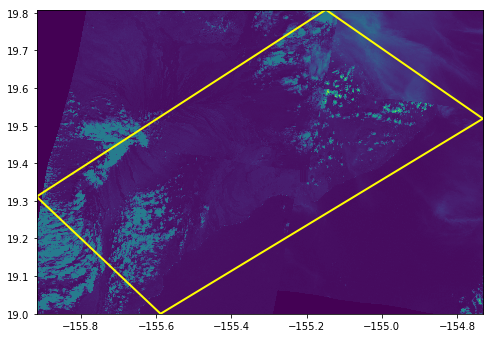

In [70]:
# Plot red band  

red_extent = plotting_extent(post_red_mosaic[0], transform = post_red_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(post_red_mosaic[0], extent=red_extent)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='yellow', linewidth=2)
        
plt.show()

## Post NDVI 

In [71]:
# Caluclate NDVI on new reflectance bands 

post_ndvi = (post_nir_mosaic-post_red_mosaic)/(post_nir_mosaic+post_red_mosaic)

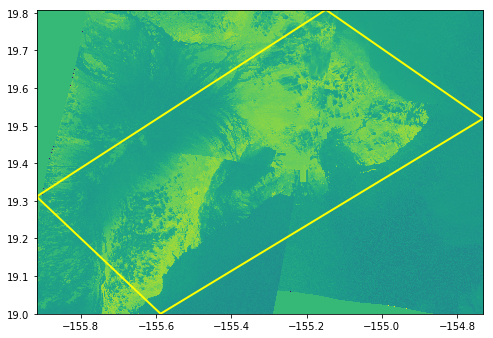

In [72]:
# Plot post NDVI 

red_extent = plotting_extent(post_red_mosaic[0], transform = post_red_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(post_ndvi[0], extent=red_extent)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='yellow', linewidth=2)
        
plt.show()

In [73]:
# Write out post ndvi 

out_path_ndvi_post = '/Users/shannonwhite/git/data/ASTER/outputA/post_ndvi_rf.tif'

with rio.open(out_path_ndvi_post,"w",**ast_pre_red_out_meta) as dest:
    dest.write(post_ndvi)

In [74]:
# Read in pre/post ndvi to confirm shapes are the same

with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/post_ndvi_rf.tif") as post_ndvi:
    post = post_ndvi.read()
    post_profile = post_ndvi.profile


with rio.open("/Users/shannonwhite/git/data/ASTER/outputA/pre_ndvi_rf.tif") as pre_ndvi:
    pre = pre_ndvi.read()
    pre_profile = pre_ndvi.profile

In [75]:
post.shape

(1, 4909, 5825)

In [76]:
pre.shape

(1, 4909, 5825)

In [77]:
# Calculate dNDVI = pre-post
dndvi_a = pre - post 

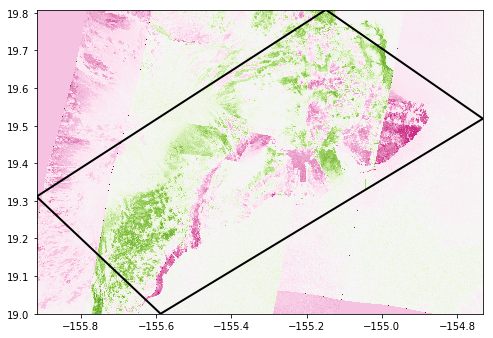

In [78]:
# Plot dNDVI with boundary 

red_extent = plotting_extent(post_red_mosaic[0], transform = post_red_out_trans)

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(dndvi_a[0],cmap='PiYG',
              vmin=-1,
              vmax=1, extent=red_extent)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='black', linewidth=2)
        
plt.show()

(array([8.4900000e+02, 2.4880000e+03, 2.1651000e+04, 8.9131400e+05,
        5.3609420e+06, 1.8920109e+07, 2.6871470e+06, 7.0698700e+05,
        1.3700000e+03, 2.0680000e+03]),
 array([-1.63861438, -1.33824501, -1.03787563, -0.73750626, -0.43713688,
        -0.13676751,  0.16360187,  0.46397124,  0.76434062,  1.06470999,
         1.36507937]),
 <a list of 10 Patch objects>)

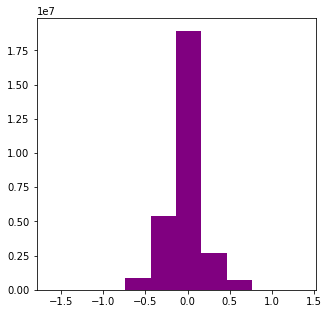

In [79]:

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(dndvi_a.ravel(), color='purple')

In [80]:
# Write out dNDVI 

out_path_dndvi = '/Users/shannonwhite/git/data/ASTER/outputA/dndvi_aster.tif'

with rio.open(out_path_dndvi,"w",**ast_pre_red_out_meta) as dest:
    dest.write(dndvi_a)